In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.vision.gan import *
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress
import torch
import argparse
from models.utils.joiner2 import GAN
from models.utils.losses import *
from models.utils.metrics import *
from models.utils.misc import *
from models.unet import UNet

from torchvision import datasets, transforms, models
import torchvision.transforms as T

In [4]:
H = 32
W= 32
bs = 5
nclass = 10
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
#path = './data/ImageNetRotation1k/'
path = untar_data(URLs.CIFAR)

transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transform)

dloader = data.dataloaders(path,bs=bs) 

In [6]:
len(dloader.valid)

2400

In [7]:
#dloader.show_batch()

In [8]:
GanLoss = GanLossWrapper(beta=0, gamma=0.005,sigma=1)

gan = GAN(num_encoder_layers = 4, nhead=4, backbone = False, num_classes = nclass, bypass=False, hidden_dim=256, 
          batch_size=bs, image_h=H, image_w=W,grid_l=4,penalty_factor="2")

In [9]:
learner = Learner(dloader, gan, loss_func=GanLoss, metrics=[Adversarial_loss, Reconstruction_Loss, Accuracy])
#critic_learn = Learner(dloader, gan, loss_func=critic_loss, metrics=[Accuracy, Critic_Attention_loss])
#generator_learn = Learner(dloader, gan, loss_func=generator_loss, metrics=[Generator_Attention_loss, Adversarial_loss, Reconstruction_Loss])

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0008317637839354575)

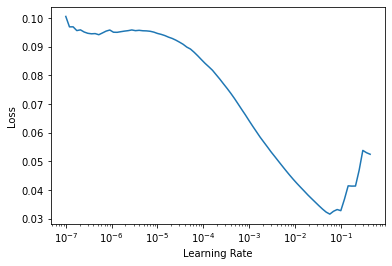

In [10]:
learner.model.noise_mode = True
for param in learner.model.generator.parameters():
    param.requires_grad = True
for param in learner.model.model.parameters():
    param.requires_grad = False
learner.model.noise_mode = True
learner.loss_func.generator_mode = True
learner.lr_find()

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=1.3182567499825382e-06)

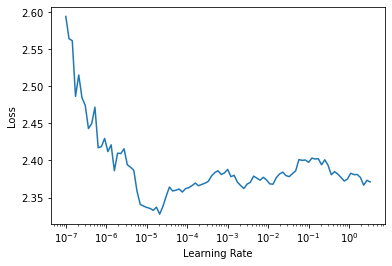

In [11]:
learner.model.noise_mode = False
for param in learner.model.generator.parameters():
    param.requires_grad = False
fb = ["mask","penalty_mask","pos"]
for name, p in learner.model.model.named_parameters(): 
    if name not in fb:
        p.requires_grad_(True)
learner.loss_func.generator_mode = False
learner.lr_find()

In [12]:
epochs = 3
for e in range(epochs):
    print("Epoch", e+1)
    print("Generator training")
    #Generator Training
    learner.model.generator_mode == True
    learner.loss_func.generator_mode = True
    learner.model.noise_mode = True
    
    for param in learner.model.generator.parameters():
        param.requires_grad = True
    for param in learner.model.model.parameters():
        param.requires_grad = False
    
    learner.fit_one_cycle(1,0.001)
    
    print("Critit training without noised images")
    
    learner.model.generator_mode == False
    learner.loss_func.generator_mode = False
    
    #Critit training without noised images
    for param in learner.model.generator.parameters():
        param.requires_grad = False
    fb = ["mask","penalty_mask","pos"]
    for name, p in learner.model.model.named_parameters(): 
        if name not in fb:
            p.requires_grad_(True)
            
    learner.model.noise_mode = False
    learner.fit(1,2e-6)
    
    print("Critit training with noised images")
    #Critit training with noised images
    learner.model.noise_mode = True
    learner.fit(1,2e-6)

Epoch 1
Generator training


epoch,train_loss,valid_loss,Adversarial_loss,Reconstruction_Loss,Accuracy,time
0,-0.012032,-0.012021,-2.425923,0.000109,0.102333,10:16


Critit training without noised images


epoch,train_loss,valid_loss,Adversarial_loss,Reconstruction_Loss,Accuracy,time
0,2.369586,2.367959,-2.367959,0.000000,0.106750,08:41


Critit training with noised images


epoch,train_loss,valid_loss,Adversarial_loss,Reconstruction_Loss,Accuracy,time


KeyboardInterrupt: 

In [13]:
for name, p in learner.model.named_parameters(): 
    print(name, p.requires_grad)

generator.inc.double_conv.0.weight False
generator.inc.double_conv.0.bias False
generator.inc.double_conv.1.weight False
generator.inc.double_conv.1.bias False
generator.inc.double_conv.3.weight False
generator.inc.double_conv.3.bias False
generator.inc.double_conv.4.weight False
generator.inc.double_conv.4.bias False
generator.down1.maxpool_conv.1.double_conv.0.weight False
generator.down1.maxpool_conv.1.double_conv.0.bias False
generator.down1.maxpool_conv.1.double_conv.1.weight False
generator.down1.maxpool_conv.1.double_conv.1.bias False
generator.down1.maxpool_conv.1.double_conv.3.weight False
generator.down1.maxpool_conv.1.double_conv.3.bias False
generator.down1.maxpool_conv.1.double_conv.4.weight False
generator.down1.maxpool_conv.1.double_conv.4.bias False
generator.down2.maxpool_conv.1.double_conv.0.weight False
generator.down2.maxpool_conv.1.double_conv.0.bias False
generator.down2.maxpool_conv.1.double_conv.1.weight False
generator.down2.maxpool_conv.1.double_conv.1.bias Fa

In [14]:
checkParam = ["model.encoder.encoder.layers.3.self_attn.out_proj.weight"]
for name, p in learner.model.named_parameters(): 
    #print(name, p.requires_grad)
    if name in checkParam:
        print(p, p.requires_grad)

Parameter containing:
tensor([[ 0.0607, -0.0070, -0.0949,  ..., -0.0789,  0.0976, -0.0390],
        [-0.0802, -0.0283, -0.0019,  ...,  0.0609, -0.0744, -0.0660],
        [-0.0047, -0.0995,  0.0117,  ..., -0.0680,  0.0156,  0.0870],
        ...,
        [ 0.0378, -0.0477, -0.0623,  ..., -0.0421,  0.0231, -0.0759],
        [ 0.0888, -0.0537, -0.0265,  ..., -0.0143, -0.0750,  0.0915],
        [-0.0947,  0.0184, -0.0152,  ...,  0.0525,  0.0315,  0.0358]],
       device='cuda:0', requires_grad=True) True
